In [104]:
import librosa
import soundfile
import itertools
from aubio import source, onset
import numpy as np
import math
import os
from os.path import join
import json
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

In [103]:
wav_lst = os.listdir(join('ZD20K', 'outputs'))
sr = 24000

## Librosa

In [148]:
def librosa_onsets(file_path, fs=24000, mode='env'):
    signal, fs = librosa.load(file_path, sr=fs)
    
    if mode == 'time':
        ### wait: gap between peaks; pre/post_max/avg: windowing; delta: threshold ###
        try:
            onset_ts = librosa.onset.onset_detect(signal, sr=fs, units='time', backtrack=True, 
                                                  wait=1, pre_avg=1, post_avg=1, pre_max=1, post_max=1, delta=0.2)
        except:
            return np.array([])
        #onset_ts = librosa.onset.onset_detect(signal, sr=fs, units='time', backtrack=True)
    elif mode == 'env':
        o_env = librosa.onset.onset_strength(signal, sr=fs)
        times = librosa.times_like(o_env, sr=fs)
        onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=fs, backtrack=True)
        onset_ts = librosa.frames_to_time(onset_frames)
        
        D = np.abs(librosa.stft(signal))
        fig, ax = plt.subplots(1, 1)
        ax.set_title('Librosa Onset Detection')
        ax.plot(times, o_env, label='Onset strength')
        ax.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
           linestyle='--', label='Onsets')
        ax.legend()
        ax.set_xlabel('Time (s)')
    else:
        raise ValueError("Do not support this mode!")
        
    return onset_ts

In [119]:
signal ,fs = librosa.load(join('ZD20K', 'outputs', wav_lst[0]), sr=sr)

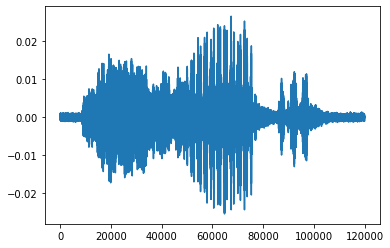

In [120]:
plt.plot(signal)
plt.show()

array([  2,   4,  12,  18,  26,  32,  34,  41,  44,  51,  54,  59,  61,
        71,  77,  82,  84,  95, 104, 110, 115, 121, 123, 128, 130, 133,
       138, 141, 144, 146, 149, 154, 156, 159, 161, 164, 186, 199, 215,
       221, 241, 251, 271, 281, 288, 296, 306, 312, 318, 321, 324])

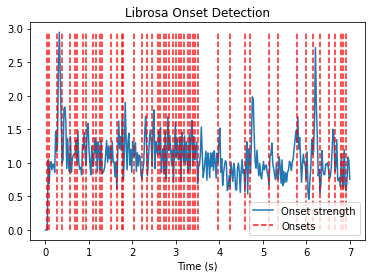

In [43]:
librosa_onsets(join('outputs', wav_lst[0]))  # After backtrack=True

In [46]:
librosa_onsets(join('outputs', wav_lst[0]), mode='time')  # After backtrack=True, 'time'

array([0.04266667, 0.08533333, 0.256     , 0.384     , 0.55466667,
       0.68266667, 0.72533333, 0.87466667, 0.93866667, 1.088     ,
       1.152     , 1.25866667, 1.30133333, 1.51466667, 1.64266667,
       1.74933333, 1.792     , 2.02666667, 2.21866667, 2.34666667,
       2.45333333, 2.58133333, 2.624     , 2.73066667, 2.77333333,
       2.83733333, 2.944     , 3.008     , 3.072     , 3.11466667,
       3.17866667, 3.28533333, 3.328     , 3.392     , 3.43466667,
       3.49866667, 3.968     , 4.24533333, 4.58666667, 4.71466667,
       5.14133333, 5.35466667, 5.78133333, 5.99466667, 6.144     ,
       6.31466667, 6.528     , 6.656     , 6.784     , 6.848     ,
       6.912     ])

In [61]:
librosa_onsets(join('outputs', wav_lst[0]), mode='time')  # After backtrack=True, 'time' with peak_pick args

array([0.04266667, 0.21333333, 0.256     , 0.384     , 1.792     ,
       2.73066667, 2.77333333, 3.11466667, 4.65066667, 4.71466667,
       6.144     ])

In [132]:
librosa_onsets(join('ZD20K', 'outputs', wav_lst[0]), mode='time') # Default setting!? After delta=0.2

array([0.32 , 0.576])

In [133]:
lib_count_lst = []

for file in os.listdir(join('ZD20K', 'outputs')):
    onset_time = librosa_onsets(join('ZD20K', 'outputs', file), mode='time')
    lib_count_lst.append((len(onset_time), onset_time.tolist()))
    if len(lib_count_lst) > 9:
        break
    
print(lib_count_lst)

[(2, [0.32, 0.576]), (1, [2.24]), (1, [0.8533333333333334]), (4, [0.256, 0.49066666666666664, 2.026666666666667, 2.8586666666666667]), (3, [0.042666666666666665, 2.0906666666666665, 2.517333333333333]), (1, [0.042666666666666665]), (1, [1.6853333333333333]), (4, [0.042666666666666665, 0.768, 0.8746666666666667, 0.9813333333333333]), (1, [0.6826666666666666]), (2, [0.042666666666666665, 3.925333333333333])]


In [63]:
assert len(lib_count_lst)==len(gt_lst)
lib_error_count = []
lib_error_onset_t = []
for idx, tup in enumerate(lib_count_lst):
    lib_error_count.append(abs(tup[0] - gt_lst[idx][0]))
    # compute onset_t differences of different size
    
print(sum(lib_error_count) / len(lib_error_count))

12.2


## Aubio

In [135]:
def get_onset_times(file_path, win_div=4):
    window_size = 1024 # FFT size
    hop_size = window_size // win_div

    sample_rate = 0
    src_func = source(file_path, sample_rate, hop_size)
    sample_rate = src_func.samplerate
    onset_func = onset('default', window_size, hop_size)
    
    duration = float(src_func.duration) / src_func.samplerate

    onset_times = [] # seconds
    while True: # read frames
        samples, num_frames_read = src_func()
        if onset_func(samples):
            onset_time = onset_func.get_last_s()
            if onset_time < duration:
                onset_times.append(onset_time)
            else:
                break
        if num_frames_read < hop_size:
            break
    
    return onset_times

In [136]:
file_path = join('ZD20K', 'outputs', wav_lst[0])
onset_times = get_onset_times(file_path)

In [143]:
count_lst = []

for file in os.listdir(join('ZD20K', 'outputs')):
    onset_time = get_onset_times(join('ZD20K', 'outputs', file), win_div=2)
    count_lst.append((len(onset_time), onset_time))
    if len(count_lst) > 9:
        break
    
print(count_lst)

[(7, [0.0, 0.2043083906173706, 0.3319047689437866, 1.1173468828201294, 1.9653061628341675, 2.059659957885742, 2.164625883102417]), (2, [1.2290703058242798, 1.7537188529968262]), (9, [0.48217687010765076, 0.6090475916862488, 1.3082993030548096, 1.517346978187561, 1.5733786821365356, 1.6295918226242065, 1.6893877983093262, 1.7456235885620117, 1.8044670820236206]), (10, [0.1531972736120224, 0.2757823169231415, 0.3731292486190796, 0.4663265347480774, 0.575986385345459, 0.7185714244842529, 0.7724036574363708, 0.8351020216941833, 1.6122221946716309, 1.7330158948898315]), (2, [0.0, 0.7468934059143066]), (1, [0.0]), (3, [0.9247392416000366, 1.2026077508926392, 1.2604762315750122]), (7, [0.15768706798553467, 0.2146485298871994, 0.26573696732521057, 0.3880952298641205, 1.1408843994140625, 1.2304534912109375, 1.338344693183899]), (6, [0.0, 0.41814059019088745, 0.9612471461296082, 1.346258521080017, 1.4593197107315063, 1.5599772930145264]), (1, [0.0])]


In [3]:
with open('annotations.json') as f:
    anns = json.load(f)

### Ground-truth

In [21]:
gt_lst = []

for file in os.listdir('outputs'):
    key_name = file.split('.')[0]
    
    start_ts = [item['start_t'] for item in anns[key_name]['birds']]
    
    gt_lst.append((anns[key_name]['count'], sorted(start_ts)))
    
print(gt_lst)

[(10, [0.015876305004615496, 0.04055874747533283, 0.8560014930756557, 1.113190095751739, 1.4673785172424894, 1.8090983152621483, 1.9343189066546818, 2.1345905017997007, 4.339293069060367, 5.427446743592197]), (10, [0.37726755844016974, 0.39026541015092964, 0.865730286394628, 1.289283348606935, 1.3144453738689539, 2.045300700875337, 4.526546265432463, 4.606212095954632, 4.9642929183415685, 5.358079898350199]), (10, [2.0422582831429015, 2.4019279826428646, 3.684572612475001, 4.631383724230315, 5.174263512148089, 5.808403381671271, 7.213222444554427, 7.247640891734407, 8.61479029189398, 9.305477105584105]), (10, [0.08957469750368154, 0.7055040435527499, 0.7437540168754013, 1.1322561652724625, 1.1368965504921866, 2.508784130854608, 2.9445331997541864, 3.1993645288836, 3.36240098300053, 4.24348693561246]), (10, [0.7902820896082009, 0.8351156931336404, 0.9657154572200708, 2.8727539475059127, 4.742736772641742, 4.8263467105994025, 6.537025166068086, 7.504311641580494, 7.643364108606821, 7.805

In [22]:
assert len(count_lst)==len(gt_lst)
error_count = []
error_onset_t = []
for idx, tup in enumerate(count_lst):
    error_count.append(abs(tup[0] - gt_lst[idx][0]))
    # compute onset_t differences of different size
    
print(sum(error_count) / len(error_count))

3.6


# TUT-SED Synthetic 2016

In [1]:
path_to_meta = "/home/zdai/repos/TUT-SED_Synthetic_2016/TUT-SED-synthetic-2016.meta/TUT-SED-synthetic-2016/meta"

In [19]:
TUT = {}
max_event_t = 0.0

for filename in os.listdir(path_to_meta):
    with open(join(path_to_meta, filename), 'r') as f:
        lines = f.readlines()
    #print(lines)
    
    sound_srcs = []
    for item in lines:
        t1 = float(item.split('\t')[0])
        t2 = float(item.split('\t')[1])
        if t2 > max_event_t:
            max_event_t = t2
        cls = item.split('\t')[2][:-1]
        
        sound_srcs.append({"cls": cls,
                          "start_t": t1,
                          "end_t": t2})
    tut = {"clip_t": max_event_t,
          "events": sound_srcs}
    TUT[filename] = tut

print(len(TUT))

100


In [83]:
TUT

{'TUT-SED-synthetic-2016-annot-72.txt': {'clip_t': 345.72,
  'events': [{'cls': 'crowd_cheering', 'start_t': 11.76, 'end_t': 20.52},
   {'cls': 'crowd_cheering', 'start_t': 38.02, 'end_t': 41.12},
   {'cls': 'crowd_cheering', 'start_t': 58.64, 'end_t': 61.42},
   {'cls': 'crowd_cheering', 'start_t': 90.92, 'end_t': 99.78},
   {'cls': 'crowd_cheering', 'start_t': 134.68, 'end_t': 144.44},
   {'cls': 'crowd_cheering', 'start_t': 171.48, 'end_t': 175.3},
   {'cls': 'crowd_cheering', 'start_t': 206.12, 'end_t': 214.78},
   {'cls': 'crowd_cheering', 'start_t': 232.52, 'end_t': 241.3},
   {'cls': 'crowd_cheering', 'start_t': 256.4, 'end_t': 267.28},
   {'cls': 'crowd_cheering', 'start_t': 277.46, 'end_t': 291.16},
   {'cls': 'crowd_cheering', 'start_t': 309.44, 'end_t': 323.16},
   {'cls': 'crowd_cheering', 'start_t': 338.9, 'end_t': 345.72},
   {'cls': 'rain', 'start_t': 4.8, 'end_t': 17.54},
   {'cls': 'rain', 'start_t': 53.2, 'end_t': 67.02},
   {'cls': 'rain', 'start_t': 99.46, 'end_t': 

In [ ]:
def polyphony(clip):
    step = 0.01

    t = np.arange(0, clip['clip_t'], step)
    t_tp = np.zeros(t.shape)
    t_den = np.zeros(t.shape)
    t_area = np.zeros(t.shape)

    max_track = 0

    for idx, x in np.ndenumerate(t):
        mono_track = 0
        for instance in clip['events']:
            if x >= instance['start_t'] and x <= instance['end_t']:
                mono_track += 1

        if mono_track >= 2:
            t_tp[idx] = step
            t_den[idx] = math.e**mono_track * step
            t_area[idx] = mono_track * step

        max_track = mono_track if mono_track > max_track else max_track

    polyphonic_ratio = np.sum(t_tp) / clip['clip_t']
    polyphonic_density = np.sum(t_den) / clip['clip_t']
    # Specify Max number of "wall": donno know height of wall here
    #polyphonic_area = np.sum(t_area) / (clip['clip_t'] * 5)

    PL = max_track
    PR = polyphonic_ratio
    PD = polyphonic_density
    return PL, PR, PD

In [34]:
TUT_stats = []
max_PL = 0

for idx, (key, val) in enumerate(TUT.items()):
    pl, pr, pd = polyphony(val)
    TUT_stats.append((pl, pr, pd))
    if pl > max_PL:
        max_PL = pl
    #break
    
print(max_PL)

6


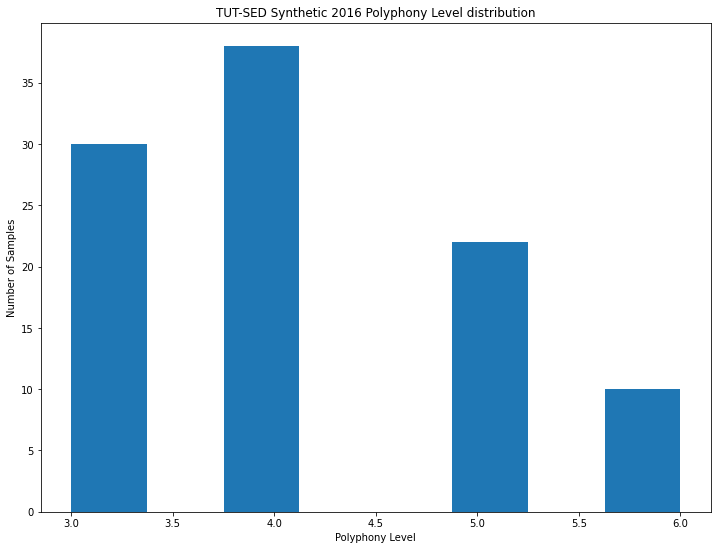

In [39]:
fig3, ax3 = plt.subplots(figsize=(12,9))
ax3.hist([int(item[0]) for item in TUT_stats], bins='auto', rwidth=0.99)
ax3.set_xlabel("Polyphony Level")
ax3.set_ylabel("Number of Samples")
ax3.set_title("TUT-SED Synthetic 2016 Polyphony Level distribution")

fig3.savefig('TUT2016_hist.png')
plt.show()

## Dataset Transformation

In [133]:
path_to_dir = "/home/zdai/repos/TUT-SED_Synthetic_2016"
dir1 = join(path_to_dir, 'TUT-SED-synthetic-2016.audio.1', 'TUT-SED-synthetic-2016', 'audio')
dir2 = join(path_to_dir, 'TUT-SED-synthetic-2016.audio.2', 'TUT-SED-synthetic-2016', 'audio')
dir3 = join(path_to_dir, 'TUT-SED-synthetic-2016.audio.3', 'TUT-SED-synthetic-2016', 'audio')
dir4 = join(path_to_dir, 'TUT-SED-synthetic-2016.audio.4', 'TUT-SED-synthetic-2016', 'audio')
dir5 = join(path_to_dir, 'TUT-SED-synthetic-2016.audio.5', 'TUT-SED-synthetic-2016', 'audio')

sr = 24000

clip_t = 5

In [146]:
tut_dir = 'TUT2016'
os.makedirs(join(tut_dir, 'outputs')) if not os.path.exists(join(tut_dir, 'outputs')) else None

annotations = {}

for file in os.listdir(dir5):
    signal, fs = librosa.load(join(dir5, file), sr=sr)
    
    fileidx = file.split('.')[0].split('-')[-1]
    wavname = 'TUT-SED-synthetic-2016-mix-' + fileidx
    annname = 'TUT-SED-synthetic-2016-annot-' + fileidx
    
    num_clips = len(signal) // (clip_t * sr)
    
    for index in range(num_clips):
        
        filename = "mix-{}_index-{}".format(int(fileidx), index)
        
        # Create .wav
        soundfile.write(file=join(tut_dir, 'outputs', filename+'.wav'), 
                        data=signal[index * clip_t * sr:(index+1) * clip_t * sr], 
                        samplerate=sr)
        
        # Add annotation
        ann = create_wav_ann(TUT[annname+'.txt'], index * clip_t, (index+1) * clip_t, sr)
        
        annotations[filename] = ann
        
        #if index >=10:
        #    break
    #break

            
if os.path.exists(join(tut_dir, 'TUTannotations.json')):
    with open(join(tut_dir, 'TUTannotations.json')) as f:
        new_anns = json.load(f)

    new_anns.update(annotations)
    with open(join(tut_dir, 'TUTannotations.json'), 'w', encoding='utf-8') as f:
        json.dump(new_anns, f, ensure_ascii=False, indent=4)
else:
    with open(join(tut_dir, 'TUTannotations.json'), 'w', encoding='utf-8') as f:
        json.dump(annotations, f, ensure_ascii=False, indent=4)
print("Simulation Completed!")

Simulation Completed!


In [144]:
def create_wav_ann(tut, start_t, end_t, sr):
    
    step = 0.01

    t = np.arange(start_t, end_t, step)
    t_tp = np.zeros(t.shape)
    t_den = np.zeros(t.shape)
    t_area = np.zeros(t.shape)
    
    max_track = 0
    sound_srcs = []
    
    for instance in tut['events']:
        if start_t < instance['end_t'] and end_t > instance['start_t']:
            t1 = instance['start_t'] if instance['start_t']>start_t else start_t
            t2 = instance['end_t'] if instance['end_t']<end_t else end_t
            sound_srcs.append({"BirdName": instance['cls'],
                                      "start_t": t1 % (end_t - start_t),
                                      "end_t": t2 % (end_t - start_t)})

    for idx, x in np.ndenumerate(t):
        mono_track = 0
        for instance in tut['events']:
            if x > instance['start_t'] and x < instance['end_t']:
                mono_track += 1
                
        if mono_track >= 2:
            t_tp[idx] = step
            t_den[idx] = math.e**mono_track * step
            t_area[idx] = mono_track * step

        max_track = mono_track if mono_track > max_track else max_track

    polyphonic_ratio = np.sum(t_tp) / (end_t - start_t)
    polyphonic_density = np.sum(t_den) / (end_t - start_t)
    # Specify Max number of "wall": donno know height of wall here
    polyphonic_area = np.sum(t_area) / (end_t - start_t)

    PL = max_track
    PR = polyphonic_ratio
    PD = polyphonic_density
    PA = polyphonic_area
    
    item = {
             'fs': sr,
             'clip_length': end_t - start_t,
             'birds': sound_srcs,
             'count': len(sound_srcs),
             'PolyphonicRatio': PR,
             'PolyphonicDensity': PD,
             'PolyphonyLevel': PL,
             'PolyphonicArea': PA,
            }
    
    return item

# Evaluation

In [ ]:
# Load annotations
with open(join('annotations_pred.json')) as f:
    anns = json.load(f)

with open(join('annotations_pred_6_10.json')) as f:
    anns6_10 = json.load(f)
    
anns.update(anns6_10)
print(len(anns))

In [40]:
# Load Rooster-only annotation
with open(join('annotations_pred_6_10_rooster.json')) as f:
    anns = json.load(f)
print(len(anns))

80000


## Librosa & Aubio eval

In [101]:
lib_count_lst, aub_count_lst = [], []

for file in os.listdir(join('ZD20K', 'outputs')):
    onset_time = librosa_onsets(join('ZD20K', 'outputs', file), mode='time')
    onset_times_aub = get_onset_times(join('ZD20K', 'outputs', file), win_div=2)
    
    lib_count_lst.append((len(onset_time), onset_time.tolist()))
    aub_count_lst.append((len(onset_times_aub), onset_times_aub))
    break
    
print(lib_count_lst, aub_count_lst)

[(12, [0.042666666666666665, 0.32, 0.576, 1.8986666666666667, 2.048, 2.2186666666666666, 2.3253333333333335, 2.432, 2.538666666666667, 2.6453333333333333, 3.0933333333333333, 3.541333333333333])] [(19, [0.0, 0.20789115130901337, 0.33396825194358826, 1.1109297275543213, 1.1709524393081665, 1.2301360368728638, 1.2886848449707031, 1.3488208055496216, 1.4080045223236084, 1.4671655893325806, 1.5267120599746704, 1.5873695611953735, 1.646417260169983, 1.7078458070755005, 1.9541043043136597, 2.0360543727874756, 2.093038558959961, 2.145986318588257, 2.1974830627441406])]


In [149]:
num_of_onset_samples = 0
for index, (filename, item) in enumerate(anns.items()):
    if item['count_num_pred'] is not None:
        if os.path.isfile(join('ZD20K', 'outputs', filename + '.wav')):
            path_to_file = join('ZD20K', 'outputs', filename + '.wav')
        elif os.path.isfile(join('ZD20K_count6-10', 'outputs', filename + '.wav')):
            path_to_file = join('ZD20K_count6-10', 'outputs', filename + '.wav')
        else:
            raise ValueError(filename + '.wav', " does not exist!")
            
        onset_time = librosa_onsets(path_to_file, mode='time')
        librosa_count = len(onset_time)
        anns[filename]['count_num_lib'] = librosa_count
        
        onset_times_aub = get_onset_times(path_to_file, win_div=2)
        aub_count = len(onset_times_aub)
        anns[filename]['count_num_aub'] = aub_count
        
        num_of_onset_samples += 1
        
print("Detected total samples = ", num_of_onset_samples)

Detected total samples =  9998


In [151]:
# Save updated anns with gt-lib & aub
with open('annotations_count1-10_lib_aub.json', 'w', encoding='utf-8') as f:
    json.dump(anns, f, ensure_ascii=False, indent=4)

## Count Correlation to P.L. P.R. P.A. P.D.

In [3]:
sort_attr = 'PolyphonyLevel'
PR_lst = sorted(anns.items(), key=lambda x: x[1][sort_attr], reverse=True)

In [4]:
len(PR_lst)

40000

In [5]:
count_lst, pl_lst, pa_lst, pr_lst, pd_lst = [], [], [], [], []

for item in PR_lst:
    pl_lst.append(item[1]['PolyphonyLevel'])
    pa_lst.append(item[1]['PolyphonicArea'])
    pr_lst.append(item[1]['PolyphonicRatio'])
    pd_lst.append(item[1]['PolyphonicDensity'])
    count_lst.append(item[1]['count'])

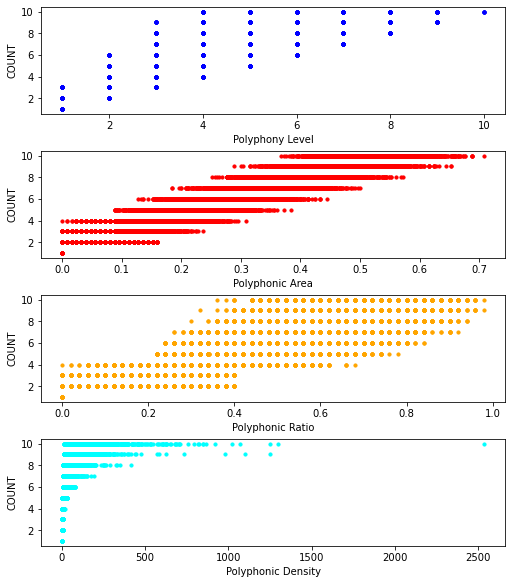

In [6]:
fig, ax = plt.subplots(4, 1, figsize=(7, 8), constrained_layout=True)

ax[0].scatter(pl_lst, count_lst, color='b', s=10)
ax[0].set_xlabel("Polyphony Level")
ax[0].set_ylabel("COUNT")

ax[1].scatter(pa_lst, count_lst, color='r', s=10)
ax[1].set_xlabel("Polyphonic Area")
ax[1].set_ylabel("COUNT")

ax[2].scatter(pr_lst, count_lst, color='orange', s=10)
ax[2].set_xlabel("Polyphonic Ratio")
ax[2].set_ylabel("COUNT")

ax[3].scatter(pd_lst, count_lst, color='cyan', s=10)
ax[3].set_xlabel("Polyphonic Density")
ax[3].set_ylabel("COUNT")

#fig.savefig('ZD20K_distribution', facecolor='white', transparent=False)
plt.show()

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


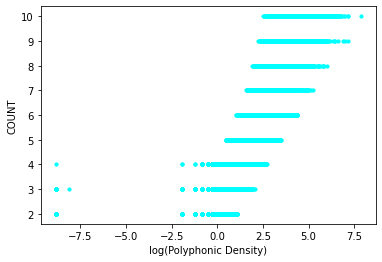

In [7]:
fig2, ax2 = plt.subplots()

ax2.scatter(np.log(pd_lst), count_lst, color='cyan', s=10)
ax2.set_xlabel("log(Polyphonic Density)")
ax2.set_ylabel("COUNT")

#fig2.savefig('ZD20K_log-polyphonicDensity', facecolor='white', transparent=False)
plt.show()

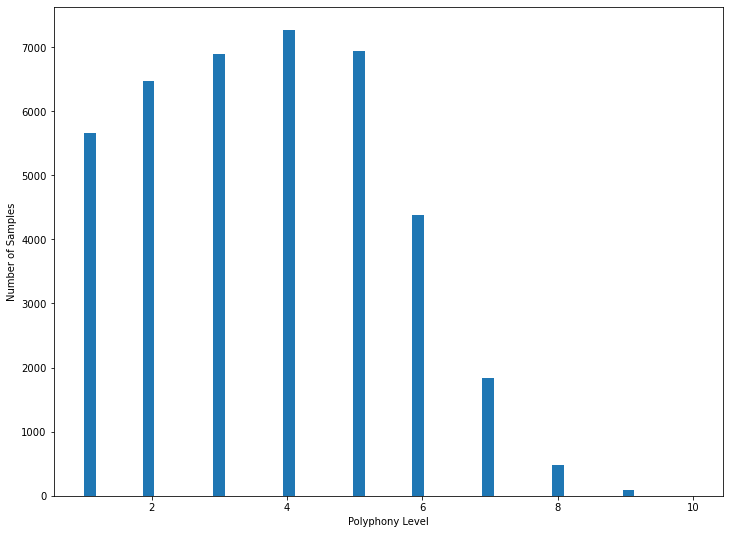

In [11]:
fig3, ax3 = plt.subplots(figsize=(12,9))
ax3.hist(pl_lst, bins='auto', rwidth=0.99)
ax3.set_xlabel("Polyphony Level")
ax3.set_ylabel("Number of Samples")

#fig3.savefig('ZD20K_hist')
plt.show()

## Polyphony Level

In [138]:
# Load annotations
with open(join('annotations_pred.json')) as f:
    anns = json.load(f)

with open(join('annotations_pred_6_10.json')) as f:
    anns6_10 = json.load(f)

anns.update(anns6_10)
print(len(anns))

40000


In [111]:
# Load Rooster-only annotation
with open(join('annotations_pred_6_10_rooster.json')) as f:
    anns = json.load(f)
    
with open(join('annotations_pred_1_5_rooster.json')) as f:
    anns1_5 = json.load(f)

anns1_5_firsthalf = dict(itertools.islice(anns1_5.items(), 20000))

anns.update(anns1_5_firsthalf)
print(len(anns))

80000


In [97]:
hist_thres = 10

In [98]:
def eval_polyphony(ann, sort_attr = 'PolyphonyLevel'):
    
    PR_lst = sorted(ann.items(), key=lambda x: x[1][sort_attr], reverse=False)
    
    attr_lst = []
    count_num_pred_lst, count_lst = [], []
    snr_lst = []
    lib_lst, aub_lst = [], []

    for item in PR_lst:
        if item[1]['count_num_pred'] is not None:
            attr_lst.append(item[1][sort_attr])
            count_lst.append(item[1]['count'])
            count_num_pred_lst.append(item[1]['count_num_pred'])
            snr_lst.append(item[1]['snr'])
            
            #lib_lst.append(item[1]['count_num_lib'])
            #aub_lst.append(item[1]['count_num_aub'])
            
            
    print("Number of test samples = ", len(attr_lst))
    
    return attr_lst, count_num_pred_lst, count_lst, snr_lst, lib_lst, aub_lst

In [131]:
X, Y_gt, Y_pred, SNR, Y_lib, Y_aub = eval_polyphony(anns, sort_attr = 'PolyphonyLevel')

Number of test samples =  9998


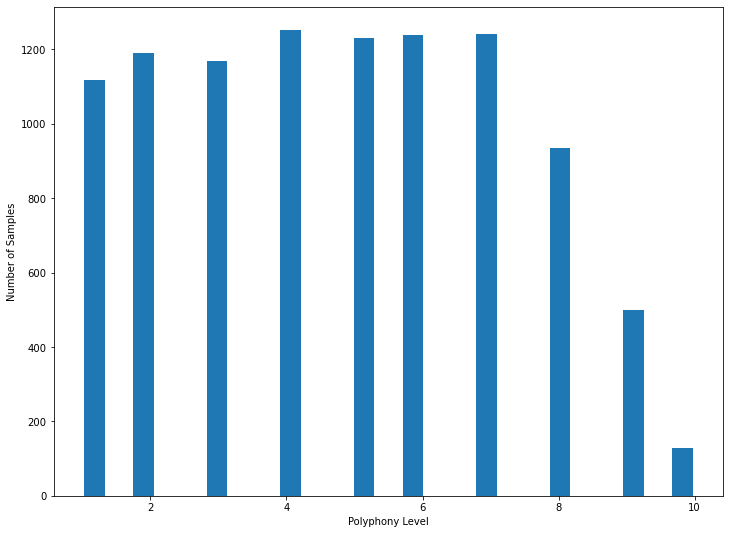

In [132]:
fig3, ax3 = plt.subplots(figsize=(12,9))
ax3.hist(X, bins='auto', rwidth=0.85)
ax3.set_xlabel("Polyphony Level")
ax3.set_ylabel("Number of Samples")

fig3.savefig('RO1-10_hist')
plt.show()

In [58]:
def get_metric(y_gt, y_pred):
    mse_sum = 0
    mde_sum = 0
    acc_sum = 0
    
    if len(y_pred) == 0:
        return None, None, None

    for idx, gt in enumerate(y_gt):
        mse_sum += abs(gt - y_pred[idx])**2
        mde_sum += abs(gt - y_pred[idx])
        if gt == y_pred[idx]:
            acc_sum += 1
    
    
    MSE = mse_sum / len(y_gt)
    MDE = mde_sum / len(y_gt)
    Accuracy = acc_sum / len(y_gt)

    print("MSE = %.3f; MDE = %.3f; Accuracy = %.2f%%" % (MSE, MDE, Accuracy*100))
    
    return MSE, MDE, Accuracy

In [114]:
PL_metric = {}
max_PL = 10

for i in range(1, max_PL + 1, 1):
    gt, pred = [], []
    pred_lib, pred_aub = [], []
    
    for idx, val in enumerate(X):
        if val == i:
            gt.append(Y_gt[idx])
            pred.append(Y_pred[idx])
            pred_lib.append(Y_lib[idx]) if len(Y_lib) != 0 else None
            pred_aub.append(Y_aub[idx]) if len(Y_aub) != 0 else None
    
    if len(gt) >= hist_thres:
        mse, mde, accu = get_metric(gt, pred)
        mse_lib, mde_lib, accu_lib = get_metric(gt, pred_lib)
        mse_aub, mde_aub, accu_aub = get_metric(gt, pred_aub)
    
        PL_metric[i] = ([mse, mse_lib, mse_aub], [mde, mde_lib, mde_aub], [accu, accu_lib, accu_aub])
    
print(PL_metric)
PL_metric_acc = [item[2][0] for item in list(PL_metric.values())]
PL_metric_MSE = [item[0][0] for item in list(PL_metric.values())]
PL_metric_MDE = [item[1][0] for item in list(PL_metric.values())]
PL_metric_acc_lib = [item[2][1] for item in list(PL_metric.values())]
PL_metric_MSE_lib = [item[0][1] for item in list(PL_metric.values())]
PL_metric_MDE_lib = [item[1][1] for item in list(PL_metric.values())]
PL_metric_acc_aub = [item[2][2] for item in list(PL_metric.values())]
PL_metric_MSE_aub = [item[0][2] for item in list(PL_metric.values())]
PL_metric_MDE_aub = [item[1][2] for item in list(PL_metric.values())]

MSE = 1.283; MDE = 0.991; Accuracy = 15.32%
MSE = 0.473; MDE = 0.438; Accuracy = 57.98%
MSE = 1.331; MDE = 0.900; Accuracy = 28.74%
MSE = 3.886; MDE = 1.838; Accuracy = 0.88%
MSE = 5.124; MDE = 2.097; Accuracy = 4.63%
MSE = 2.751; MDE = 1.357; Accuracy = 19.29%
MSE = 1.364; MDE = 0.898; Accuracy = 31.35%
MSE = 1.544; MDE = 0.966; Accuracy = 29.76%
MSE = 2.576; MDE = 1.384; Accuracy = 14.26%
MSE = 3.805; MDE = 1.789; Accuracy = 4.69%
{1: ([1.2831541218637992, None, None], [0.9910394265232975, None, None], [0.1532258064516129, None, None]), 2: ([0.473109243697479, None, None], [0.43781512605042017, None, None], [0.5798319327731093, None, None]), 3: ([1.3310521813515825, None, None], [0.8999144568006844, None, None], [0.2874251497005988, None, None]), 4: ([3.885782747603834, None, None], [1.8378594249201279, None, None], [0.00878594249201278, None, None]), 5: ([5.124289195775792, None, None], [2.0974817221770916, None, None], [0.0463038180341186, None, None]), 6: ([2.751412429378531, None

In [115]:
snr_thred = -9999  # -26.5 to differ clean/noisy; -9999 to not separate

In [83]:
# Eval performance based on SNR
PL_metric = {}
max_PL = 10

for i in range(1, max_PL + 1, 1):
    gt, pred = [], []
    gt_noisy, pred_noisy = [], []
    for idx, val in enumerate(X):
        if val == i:
            if SNR[idx] > snr_thred:
                gt.append(Y_gt[idx])
                pred.append(Y_pred[idx])
            else:
                gt_noisy.append(Y_gt[idx])
                pred_noisy.append(Y_pred[idx])
    
    if len(gt) >= hist_thres:
        mse, mde, accu = get_metric(gt, pred)
    elif len(gt)==0:
        mse, mde, accu = None, None, None
    if len(gt_noisy) >= hist_thres:
        mse_noisy, mde_noisy, accu_noisy = get_metric(gt_noisy, pred_noisy)
    elif len(gt_noisy)==0:
        mse_noisy, mde_noisy, accu_noisy = None, None, None
    PL_metric[i] = ([mse, mse_noisy], [mde, mde_noisy], [accu, accu_noisy])
    
print(PL_metric)
PL_metric_acc = [item[2][0] for item in list(PL_metric.values())]
PL_metric_MSE = [item[0][0] for item in list(PL_metric.values())]
PL_metric_MDE = [item[1][0] for item in list(PL_metric.values())]
PL_metric_acc_noisy = [item[2][1] for item in list(PL_metric.values())]
PL_metric_MSE_noisy = [item[0][1] for item in list(PL_metric.values())]
PL_metric_MDE_noisy = [item[1][1] for item in list(PL_metric.values())]

MSE = 0.010; MDE = 0.010; Accuracy = 98.96%
MSE = 0.099; MDE = 0.089; Accuracy = 91.38%
MSE = 1.349; MDE = 0.600; Accuracy = 64.76%
MSE = 2.426; MDE = 1.125; Accuracy = 35.05%
MSE = 2.286; MDE = 1.173; Accuracy = 26.32%
MSE = 2.317; MDE = 1.198; Accuracy = 24.43%
MSE = 2.630; MDE = 1.288; Accuracy = 22.86%
MSE = 3.061; MDE = 1.485; Accuracy = 11.36%
MSE = 4.885; MDE = 1.962; Accuracy = 11.54%
{1: ([0.01043115438108484, None], [0.01043115438108484, None], [0.9895688456189151, None]), 2: ([0.09913793103448276, None], [0.08928571428571429, None], [0.9137931034482759, None]), 3: ([1.3494335122242098, None], [0.6004770423375074, None], [0.6475849731663685, None]), 4: ([2.426495248742314, None], [1.1252096143096701, None], [0.3504751257685858, None]), 5: ([2.2857142857142856, None], [1.172811059907834, None], [0.2632488479262673, None]), 6: ([2.316742081447964, None], [1.1981900452488687, None], [0.24434389140271492, None]), 7: ([2.6303418803418803, None], [1.2884615384615385, None], [0.2286

#### 1. Rooster-only

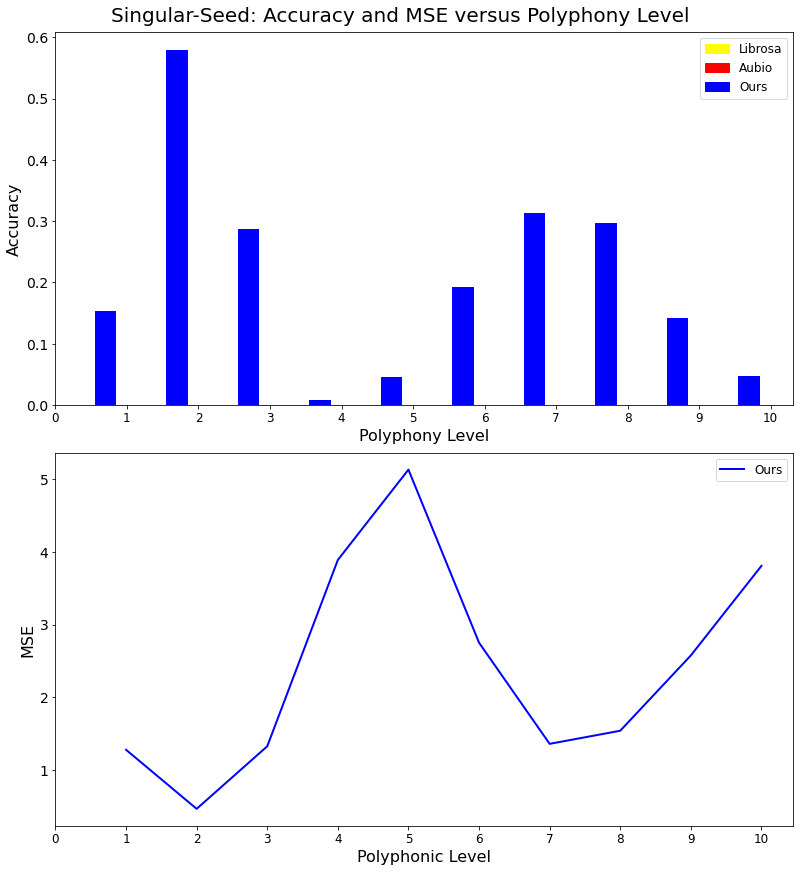

In [116]:
fig, ax = plt.subplots(2, 1, figsize=(11, 12), constrained_layout=True)
width = 0.3
x_lst = list(PL_metric)

x1 = [x - width*1.0 for x in x_lst]
ax[0].bar(x1, PL_metric_acc, color='b', 
          linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
'''
ax[0].bar(x_lst, PL_metric_acc_lib, color='y', 
          linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
x2 = [x + width*1.0 for x in x_lst]
ax[0].bar(x2, PL_metric_acc_aub, color='r', 
          linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
'''
ax[0].set_xlabel("Polyphony Level", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 

'''
ax[1].plot(list(PL_metric), PL_metric_MSE_lib, color='y', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[1].plot(list(PL_metric), PL_metric_MSE_aub, color='r', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
'''
ax[1].plot(list(PL_metric), PL_metric_MSE, color='b', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[1].set_xlabel("Polyphonic Level", fontsize=16)
ax[1].set_ylabel("MSE", fontsize=16)
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=14) 
ax[1].tick_params(axis="y", labelsize=14) 

fig.suptitle("Singular-Seed: Accuracy and MSE versus Polyphony Level", fontsize=20)

# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=range(max(x_lst) + 1), xticklabels=range(max(x_lst) + 1))

# Use the pyplot interface to change just one subplot...
plt.sca(ax[0])
plt.xticks(range(max(x_lst) + 1), range(max(x_lst) + 1), color='k', fontsize=12)
plt.sca(ax[1])
plt.xticks(range(max(x_lst) + 1), range(max(x_lst) + 1), color='k', fontsize=12)

# Legends
colors = {'Librosa':'yellow', 'Aubio':'red', 'Ours':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax[0].legend(handles, labels, prop={'size': 12})

ax[1].legend(loc='best', prop={'size': 12})

fig.savefig(join('images', 'RO1-10_PL'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#### 2. Four-birds v.s. other methods

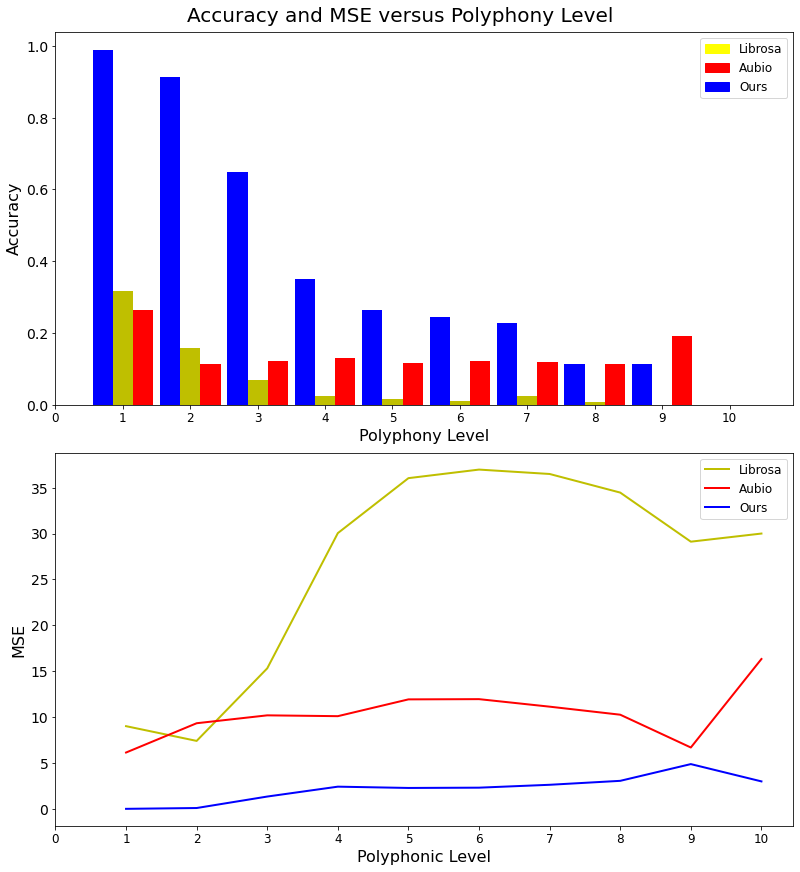

In [164]:
fig, ax = plt.subplots(2, 1, figsize=(11, 12), constrained_layout=True)
width = 0.3
x_lst = list(PL_metric)

x1 = [x - width*1.0 for x in x_lst]
ax[0].bar(x1, PL_metric_acc, color='b', 
          linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[0].bar(x_lst, PL_metric_acc_lib, color='y', 
          linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
x2 = [x + width*1.0 for x in x_lst]
ax[0].bar(x2, PL_metric_acc_aub, color='r', 
          linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[0].set_xlabel("Polyphony Level", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 

ax[1].plot(list(PL_metric), PL_metric_MSE_lib, color='y', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[1].plot(list(PL_metric), PL_metric_MSE_aub, color='r', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
ax[1].plot(list(PL_metric), PL_metric_MSE, color='b', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[1].set_xlabel("Polyphonic Level", fontsize=16)
ax[1].set_ylabel("MSE", fontsize=16)
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=14) 
ax[1].tick_params(axis="y", labelsize=14) 
'''
ax[2].plot(list(PL_metric), metric_MDE, color='g',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[2].set_xlabel("Polyphonic Level", fontsize=16)
ax[2].set_ylabel("MDE", fontsize=16)
ax[2].set_ylim([0, 1])
'''
fig.suptitle("Accuracy and MSE versus Polyphony Level", fontsize=20)

# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=range(len(PL_metric) + 1), xticklabels=range(len(PL_metric) + 1))

# Use the pyplot interface to change just one subplot...
plt.sca(ax[0])
plt.xticks(range(len(PL_metric) + 1), range(len(PL_metric) + 1), color='k', fontsize=12)
plt.sca(ax[1])
plt.xticks(range(len(PL_metric) + 1), range(len(PL_metric) + 1), color='k', fontsize=12)

# Legends
colors = {'Librosa':'yellow', 'Aubio':'red', 'Ours':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax[0].legend(handles, labels, prop={'size': 12})

ax[1].legend(loc='best', prop={'size': 12})

fig.savefig(join('images', '40K_PL'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#### 3. Attribute: SNR level

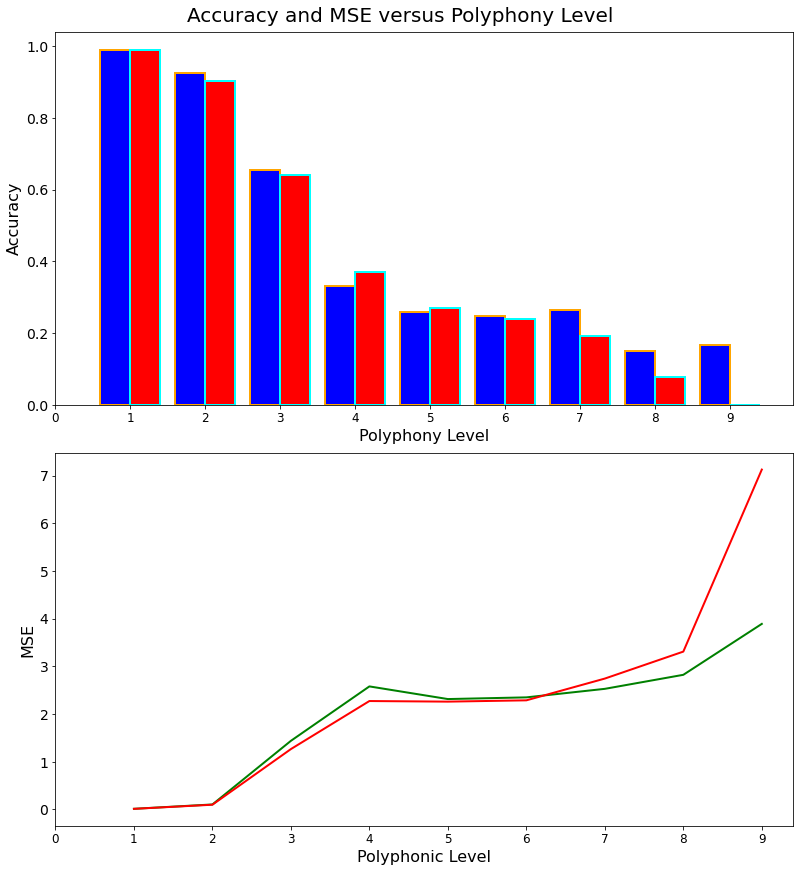

In [79]:
fig, ax = plt.subplots(2, 1, figsize=(11, 12), constrained_layout=True)
width = 0.4

x_lst = list(PL_metric)
x_lst = [x-width/2 for x in x_lst]
ax[0].bar(x_lst, PL_metric_acc, color='b', 
       edgecolor='orange', linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
x_lst2 = list(PL_metric)
x_lst2 = [x+width/2 for x in x_lst2]
ax[0].bar(x_lst2, PL_metric_acc_noisy, color='r', 
       edgecolor='cyan', linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[0].set_xlabel("Polyphony Level", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 

ax[1].plot(list(PL_metric), PL_metric_MSE, color='g', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[1].plot(list(PL_metric), PL_metric_MSE_noisy, color='r', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[1].set_xlabel("Polyphonic Level", fontsize=16)
ax[1].set_ylabel("MSE", fontsize=16)
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=14) 
ax[1].tick_params(axis="y", labelsize=14) 
'''
ax[2].plot(list(PL_metric), metric_MDE, color='g',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[2].set_xlabel("Polyphonic Level", fontsize=16)
ax[2].set_ylabel("MDE", fontsize=16)
ax[2].set_ylim([0, 1])
'''
fig.suptitle("Accuracy and MSE versus Polyphony Level", fontsize=20)

# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=range(len(PL_metric) + 1), xticklabels=range(len(PL_metric) + 1))

# Use the pyplot interface to change just one subplot...
plt.sca(ax[0])
plt.xticks(range(len(PL_metric) + 1), range(len(PL_metric) + 1), color='k', fontsize=12)
plt.sca(ax[1])
plt.xticks(range(len(PL_metric) + 1), range(len(PL_metric) + 1), color='k', fontsize=12)

fig.savefig(join('images', '40K_PL_SNR'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

## Polyphonic Ratio

In [117]:
X, Y_gt, Y_pred, _, Y_lib, Y_aub = eval_polyphony(anns, sort_attr = 'PolyphonicRatio')

Number of test samples =  9998


In [118]:
PR_metric = {}
bins = 10

for i in range(0, bins):
    gt, pred = [], []
    pred_lib, pred_aub = [], []
    
    for idx, val in enumerate(X):
        if val > i/bins and val <= i/bins + 1/bins:
            gt.append(Y_gt[idx])
            pred.append(Y_pred[idx])
            pred_lib.append(Y_lib[idx]) if len(Y_lib) != 0 else None
            pred_aub.append(Y_aub[idx]) if len(Y_aub) != 0 else None
    
    if len(gt) >= hist_thres:
        mse, mde, accu = get_metric(gt, pred)
        mse_lib, mde_lib, accu_lib = get_metric(gt, pred_lib)
        mse_aub, mde_aub, accu_aub = get_metric(gt, pred_aub)

        PR_metric[i/bins] = ([mse, mse_lib, mse_aub], [mde, mde_lib, mde_aub], [accu, accu_lib, accu_aub])
    
print(PR_metric)
PR_metric_acc = [item[2][0] for item in list(PR_metric.values())]
PR_metric_MSE = [item[0][0] for item in list(PR_metric.values())]
PR_metric_MDE = [item[1][0] for item in list(PR_metric.values())]
PR_metric_acc_lib = [item[2][1] for item in list(PR_metric.values())]
PR_metric_MSE_lib = [item[0][1] for item in list(PR_metric.values())]
PR_metric_MDE_lib = [item[1][1] for item in list(PR_metric.values())]
PR_metric_acc_aub = [item[2][2] for item in list(PR_metric.values())]
PR_metric_MSE_aub = [item[0][2] for item in list(PR_metric.values())]
PR_metric_MDE_aub = [item[1][2] for item in list(PR_metric.values())]

MSE = 0.688; MDE = 0.631; Accuracy = 39.72%
MSE = 0.519; MDE = 0.476; Accuracy = 54.59%
MSE = 0.435; MDE = 0.428; Accuracy = 57.51%
MSE = 0.330; MDE = 0.326; Accuracy = 67.64%
MSE = 1.918; MDE = 1.095; Accuracy = 24.90%
MSE = 3.901; MDE = 1.784; Accuracy = 5.56%
MSE = 3.161; MDE = 1.508; Accuracy = 14.84%
MSE = 2.577; MDE = 1.304; Accuracy = 21.47%
MSE = 2.338; MDE = 1.247; Accuracy = 21.14%
MSE = 2.080; MDE = 1.178; Accuracy = 19.25%
{0.0: ([0.6879432624113475, None, None], [0.6312056737588653, None, None], [0.3971631205673759, None, None]), 0.1: ([0.518918918918919, None, None], [0.4756756756756757, None, None], [0.5459459459459459, None, None]), 0.2: ([0.43450479233226835, None, None], [0.4281150159744409, None, None], [0.5750798722044729, None, None]), 0.3: ([0.3298538622129436, None, None], [0.325678496868476, None, None], [0.6764091858037579, None, None]), 0.4: ([1.917687074829932, None, None], [1.0945578231292517, None, None], [0.24897959183673468, None, None]), 0.5: ([3.9005376

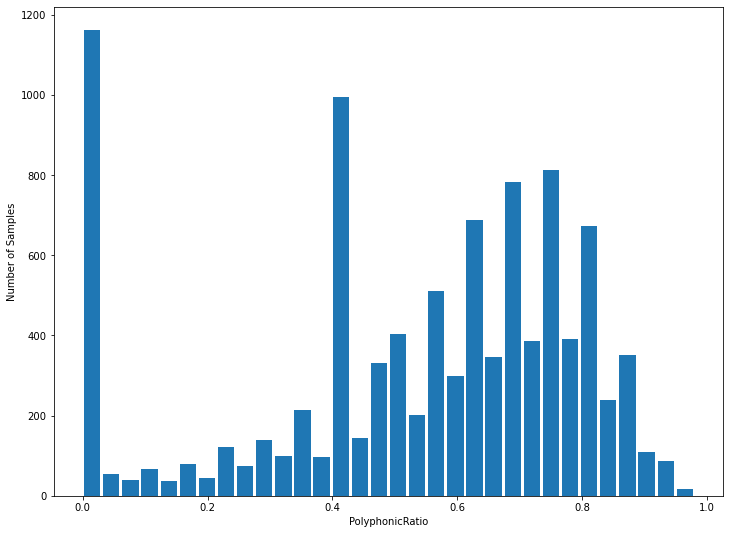

In [119]:
fig3, ax3 = plt.subplots(figsize=(12,9))
ax3.hist(X, bins='auto', rwidth=0.85)
ax3.set_xlabel("PolyphonicRatio")
ax3.set_ylabel("Number of Samples")

#fig3.savefig('ZD20K_hist')
plt.show()

#### 1. Rooster-only

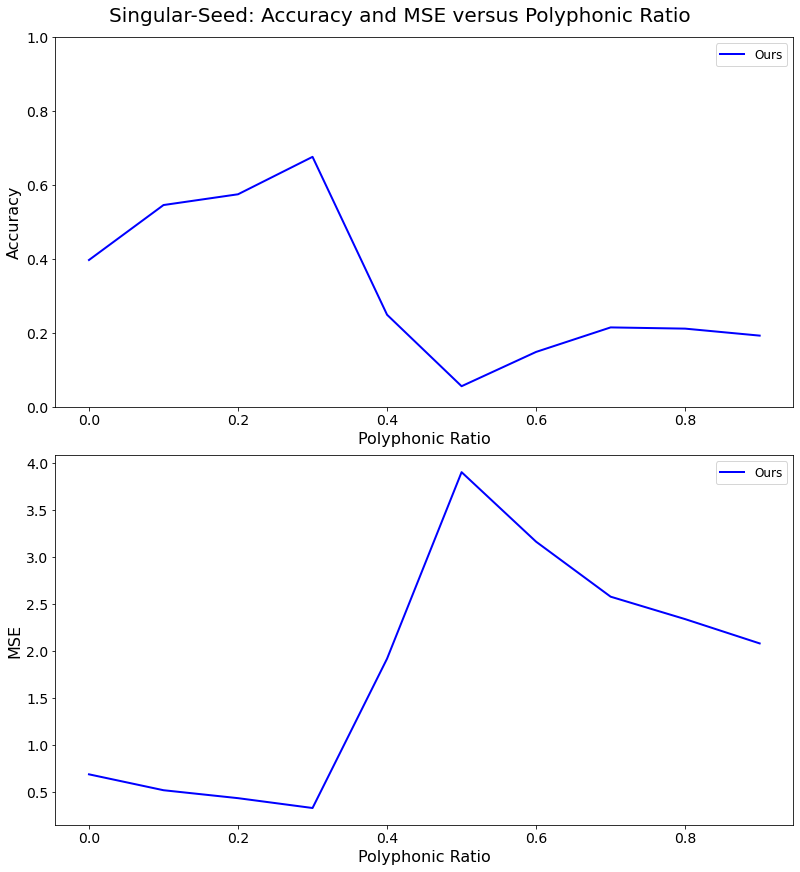

In [120]:
fig, ax = plt.subplots(2, 1, figsize=(11, 12), constrained_layout=True)
'''
ax[0].plot(list(PR_metric), PR_metric_acc_lib, color='y', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[0].plot(list(PR_metric), PR_metric_acc_aub, color='r', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
'''
ax[0].plot(list(PR_metric), PR_metric_acc, color='b', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[0].set_xlabel("Polyphonic Ratio", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].set_ylim([0, 1])
ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 

'''
ax[1].plot(list(PR_metric), PR_metric_MSE_lib, color='y', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[1].plot(list(PR_metric), PR_metric_MSE_aub, color='r', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
'''
ax[1].plot(list(PR_metric), PR_metric_MSE, color='b', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[1].set_xlabel("Polyphonic Ratio", fontsize=16)
ax[1].set_ylabel("MSE", fontsize=16)
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=14) 
ax[1].tick_params(axis="y", labelsize=14) 

fig.suptitle("Singular-Seed: Accuracy and MSE versus Polyphonic Ratio", fontsize=20)

ax[0].legend(loc='best', prop={'size': 12})
ax[1].legend(loc='best', prop={'size': 12})

fig.savefig(join('images', 'RO1-10_PR'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#### 2. Four-bird v.s. other methods

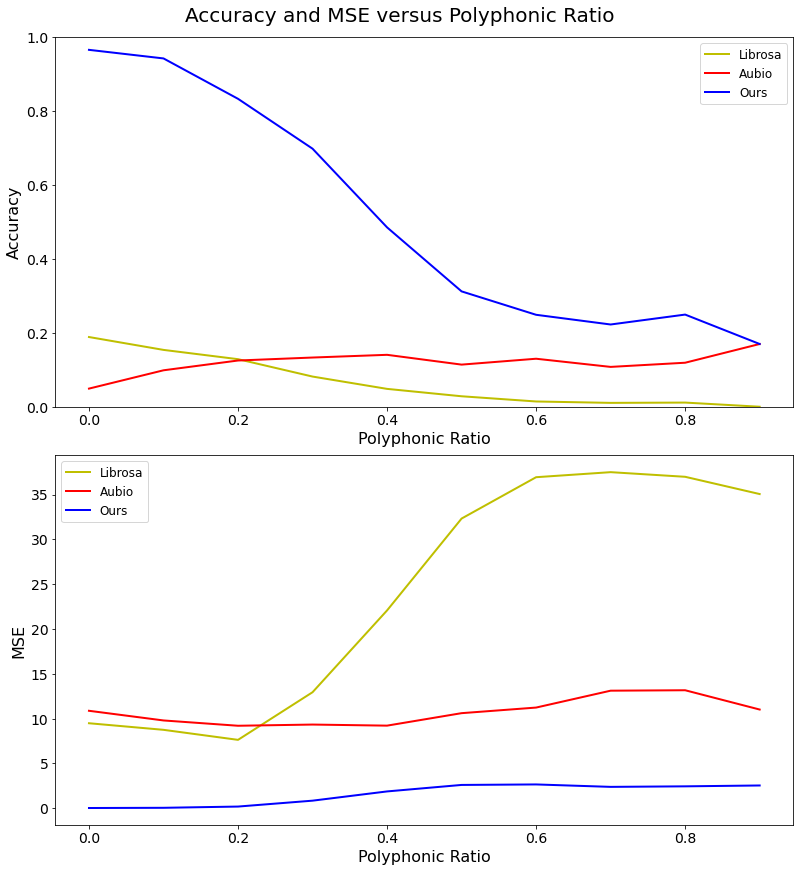

In [174]:
fig, ax = plt.subplots(2, 1, figsize=(11, 12), constrained_layout=True)

ax[0].plot(list(PR_metric), PR_metric_acc_lib, color='y', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[0].plot(list(PR_metric), PR_metric_acc_aub, color='r', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
ax[0].plot(list(PR_metric), PR_metric_acc, color='b', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[0].set_xlabel("Polyphonic Ratio", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].set_ylim([0, 1])
ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 

ax[1].plot(list(PR_metric), PR_metric_MSE_lib, color='y', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[1].plot(list(PR_metric), PR_metric_MSE_aub, color='r', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
ax[1].plot(list(PR_metric), PR_metric_MSE, color='b', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[1].set_xlabel("Polyphonic Ratio", fontsize=16)
ax[1].set_ylabel("MSE", fontsize=16)
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=14) 
ax[1].tick_params(axis="y", labelsize=14) 
'''
ax[2].plot(list(PL_metric), metric_MDE, color='g',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[2].set_xlabel("Polyphonic Level", fontsize=16)
ax[2].set_ylabel("MDE", fontsize=16)
ax[2].set_ylim([0, 1])
'''
fig.suptitle("Accuracy and MSE versus Polyphonic Ratio", fontsize=20)

ax[0].legend(loc='best', prop={'size': 12})
ax[1].legend(loc='best', prop={'size': 12})

fig.savefig(join('images', '40K_PR_lib_aub'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

## Polyphonic Area

In [121]:
X, Y_gt, Y_pred, _, Y_lib, Y_aub = eval_polyphony(anns, sort_attr = 'PolyphonicArea')

Number of test samples =  9998


In [122]:
PA_metric = {}
bins = 10

for i in range(0, bins):
    gt, pred = [], []
    pred_lib, pred_aub = [], []
    
    for idx, val in enumerate(X):
        if val > i/bins and val <= i/bins + 1/bins:
            gt.append(Y_gt[idx])
            pred.append(Y_pred[idx])
            pred_lib.append(Y_lib[idx]) if len(Y_lib) != 0 else None
            pred_aub.append(Y_aub[idx]) if len(Y_aub) != 0 else None
    
    if len(gt) >= hist_thres:
        mse, mde, accu = get_metric(gt, pred)
        mse_lib, mde_lib, accu_lib = get_metric(gt, pred_lib)
        mse_aub, mde_aub, accu_aub = get_metric(gt, pred_aub)

        PA_metric[i/bins] = ([mse, mse_lib, mse_aub], [mde, mde_lib, mde_aub], [accu, accu_lib, accu_aub])
    
print(PA_metric)
PA_metric_acc = [item[2][0] for item in list(PA_metric.values())]
PA_metric_MSE = [item[0][0] for item in list(PA_metric.values())]
PA_metric_MDE = [item[1][0] for item in list(PA_metric.values())]
PA_metric_acc_lib = [item[2][1] for item in list(PA_metric.values())]
PA_metric_MSE_lib = [item[0][1] for item in list(PA_metric.values())]
PA_metric_MDE_lib = [item[1][1] for item in list(PA_metric.values())]
PA_metric_acc_aub = [item[2][2] for item in list(PA_metric.values())]
PA_metric_MSE_aub = [item[0][2] for item in list(PA_metric.values())]
PA_metric_MDE_aub = [item[1][2] for item in list(PA_metric.values())]

MSE = 0.533; MDE = 0.497; Accuracy = 52.13%
MSE = 0.409; MDE = 0.403; Accuracy = 59.96%
MSE = 1.726; MDE = 1.168; Accuracy = 10.43%
MSE = 5.309; MDE = 2.219; Accuracy = 0.00%
MSE = 5.585; MDE = 2.225; Accuracy = 1.05%
MSE = 2.010; MDE = 1.209; Accuracy = 15.68%
MSE = 0.716; MDE = 0.586; Accuracy = 47.66%
MSE = 2.415; MDE = 1.325; Accuracy = 15.49%
MSE = 2.810; MDE = 1.476; Accuracy = 9.52%
{0.0: ([0.5334685598377282, None, None], [0.4969574036511156, None, None], [0.5212981744421906, None, None]), 0.1: ([0.40851449275362317, None, None], [0.40307971014492755, None, None], [0.5996376811594203, None, None]), 0.2: ([1.7263814616755793, None, None], [1.1684491978609626, None, None], [0.10427807486631016, None, None]), 0.3: ([5.308673469387755, None, None], [2.2185374149659864, None, None], [0.0, None, None]), 0.4: ([5.584761904761905, None, None], [2.224761904761905, None, None], [0.010476190476190476, None, None]), 0.5: ([2.009856630824373, None, None], [1.2087813620071686, None, None], [

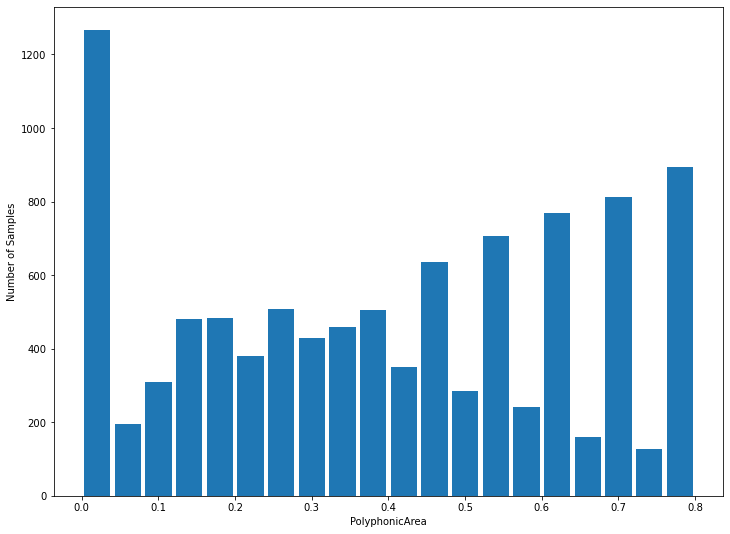

In [123]:
fig3, ax3 = plt.subplots(figsize=(12,9))
ax3.hist(X, bins='auto', rwidth=0.85)
ax3.set_xlabel("PolyphonicArea")
ax3.set_ylabel("Number of Samples")

#fig3.savefig('ZD20K_hist')
plt.show()

#### 1. Rooster-only

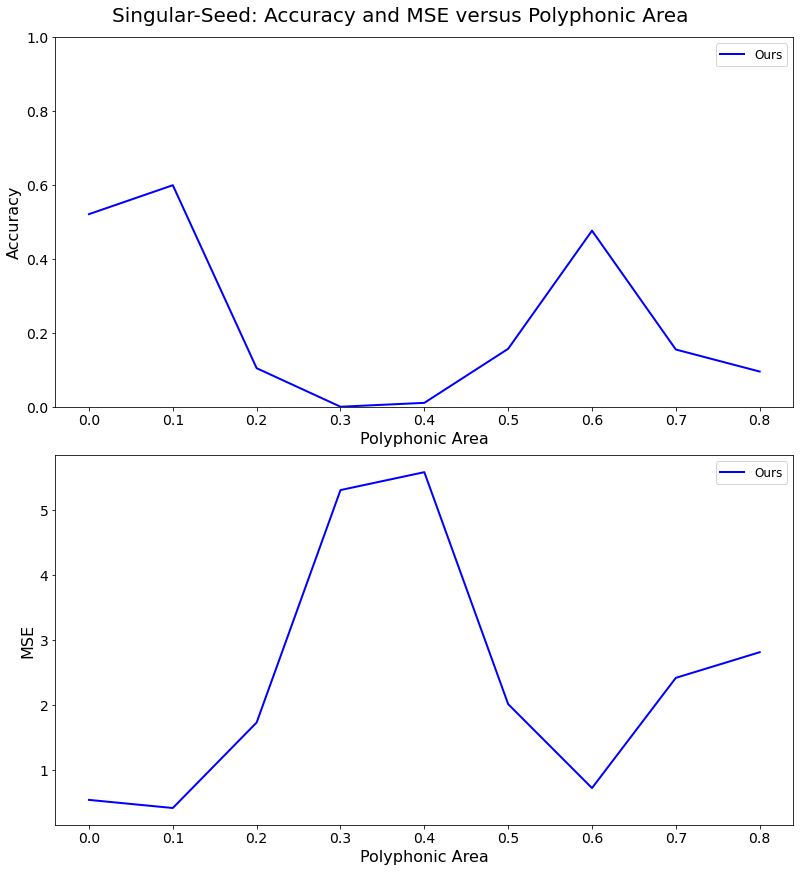

In [124]:
fig, ax = plt.subplots(2, 1, figsize=(11, 12), constrained_layout=True)

'''
ax[0].plot(list(PA_metric), PA_metric_acc_lib, color='y', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[0].plot(list(PA_metric), PA_metric_acc_aub, color='r', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
'''
ax[0].plot(list(PA_metric), PA_metric_acc, color='b', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[0].set_xlabel("Polyphonic Area", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].set_ylim([0, 1])
ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 

'''
ax[1].plot(list(PA_metric), PA_metric_MSE_lib, color='y', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[1].plot(list(PA_metric), PA_metric_MSE_aub, color='r', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
'''
ax[1].plot(list(PA_metric), PA_metric_MSE, color='b', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[1].set_xlabel("Polyphonic Area", fontsize=16)
ax[1].set_ylabel("MSE", fontsize=16)
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=14) 
ax[1].tick_params(axis="y", labelsize=14) 

fig.suptitle("Singular-Seed: Accuracy and MSE versus Polyphonic Area", fontsize=20)

ax[0].legend(loc='best', prop={'size': 12})
ax[1].legend(loc='best', prop={'size': 12})

fig.savefig(join('images', 'RO1-10_PA'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#### 2. Four-bird v.s. other methods

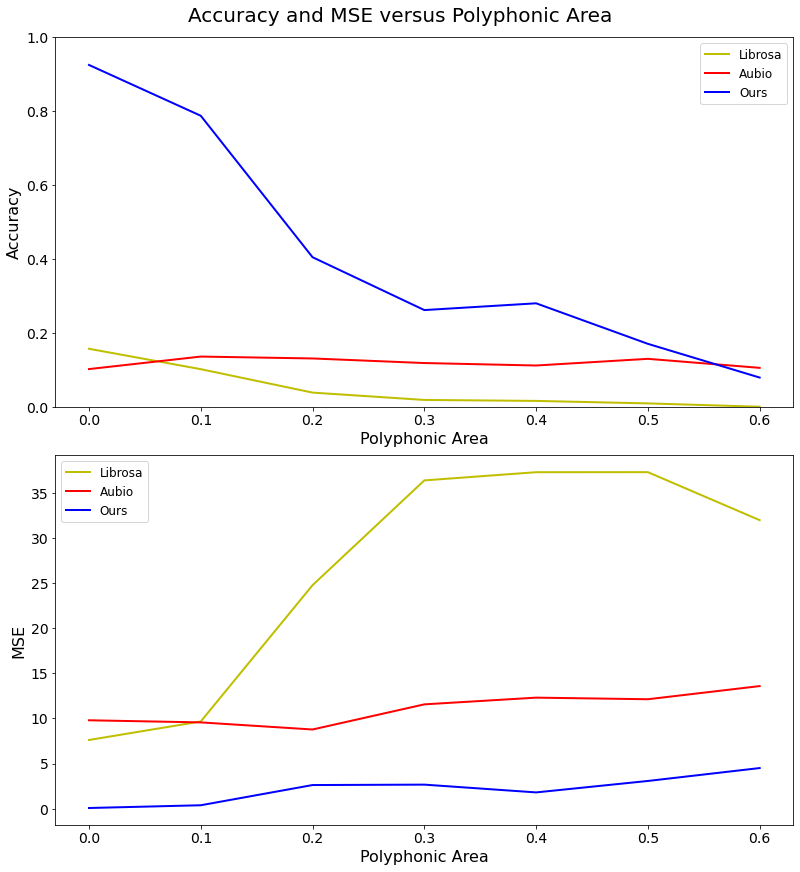

In [179]:
fig, ax = plt.subplots(2, 1, figsize=(11, 12), constrained_layout=True)

ax[0].plot(list(PA_metric), PA_metric_acc_lib, color='y', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[0].plot(list(PA_metric), PA_metric_acc_aub, color='r', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
ax[0].plot(list(PA_metric), PA_metric_acc, color='b', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[0].set_xlabel("Polyphonic Area", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].set_ylim([0, 1])
ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 

ax[1].plot(list(PA_metric), PA_metric_MSE_lib, color='y', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[1].plot(list(PA_metric), PA_metric_MSE_aub, color='r', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
ax[1].plot(list(PA_metric), PA_metric_MSE, color='b', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[1].set_xlabel("Polyphonic Area", fontsize=16)
ax[1].set_ylabel("MSE", fontsize=16)
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=14) 
ax[1].tick_params(axis="y", labelsize=14) 
'''
ax[2].plot(list(PL_metric), metric_MDE, color='g',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[2].set_xlabel("Polyphonic Area", fontsize=16)
ax[2].set_ylabel("MDE", fontsize=16)
ax[2].set_ylim([0, 1])
'''
fig.suptitle("Accuracy and MSE versus Polyphonic Area", fontsize=20)

ax[0].legend(loc='best', prop={'size': 12})
ax[1].legend(loc='best', prop={'size': 12})

fig.savefig(join('images', '40K_PA_lib_aub'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

## Polyphonic Density

In [125]:
X, Y_gt, Y_pred, _, Y_lib, Y_aub = eval_polyphony(anns, sort_attr = 'PolyphonicDensity')

Number of test samples =  9998


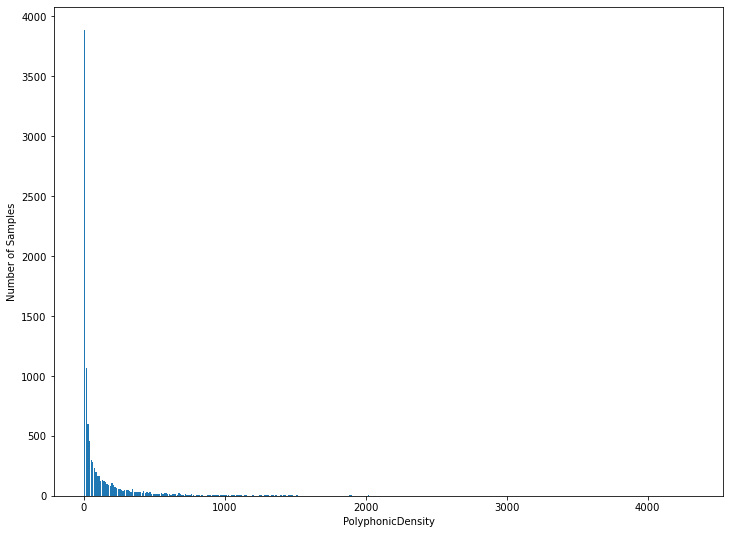

In [126]:
fig3, ax3 = plt.subplots(figsize=(12,9))
ax3.hist(X, bins='auto', rwidth=0.85)
ax3.set_xlabel("PolyphonicDensity")
ax3.set_ylabel("Number of Samples")

#fig3.savefig('ZD20K_hist')
plt.show()

In [127]:
logX = np.log(max(X))
print("Max log(PolyphonicDensity) in the test set is ", logX)

Max log(PolyphonicDensity) in the test set is  8.371469410795843


In [128]:
PD_metric = {}
bins = 10

for i in range(0, bins):
    gt, pred = [], []
    pred_lib, pred_aub = [], []
    
    for idx, val in enumerate(X):
        if val > 0:
            if np.log(val) > i*logX/bins and np.log(val) <= (i/bins + 1/bins)*logX:
                gt.append(Y_gt[idx])
                pred.append(Y_pred[idx])
                pred_lib.append(Y_lib[idx]) if len(Y_lib) != 0 else None
                pred_aub.append(Y_aub[idx]) if len(Y_aub) != 0 else None
    
    if len(gt) >= hist_thres:
        mse, mde, accu = get_metric(gt, pred)
        mse_lib, mde_lib, accu_lib = get_metric(gt, pred_lib)
        mse_aub, mde_aub, accu_aub = get_metric(gt, pred_aub)

        PD_metric[i*logX/bins] = ([mse, mse_lib, mse_aub], [mde, mde_lib, mde_aub], [accu, accu_lib, accu_aub])

    
print(PD_metric)
PD_metric_acc = [item[2][0] for item in list(PD_metric.values())]
PD_metric_MSE = [item[0][0] for item in list(PD_metric.values())]
PD_metric_MDE = [item[1][0] for item in list(PD_metric.values())]
PD_metric_acc_lib = [item[2][1] for item in list(PD_metric.values())]
PD_metric_MSE_lib = [item[0][1] for item in list(PD_metric.values())]
PD_metric_MDE_lib = [item[1][1] for item in list(PD_metric.values())]
PD_metric_acc_aub = [item[2][2] for item in list(PD_metric.values())]
PD_metric_MSE_aub = [item[0][2] for item in list(PD_metric.values())]
PD_metric_MDE_aub = [item[1][2] for item in list(PD_metric.values())]

MSE = 0.437; MDE = 0.425; Accuracy = 58.12%
MSE = 0.488; MDE = 0.445; Accuracy = 57.49%
MSE = 2.249; MDE = 1.316; Accuracy = 9.41%
MSE = 5.091; MDE = 2.149; Accuracy = 0.24%
MSE = 4.064; MDE = 1.773; Accuracy = 9.91%
MSE = 1.775; MDE = 1.027; Accuracy = 28.39%
MSE = 1.420; MDE = 0.911; Accuracy = 32.10%
MSE = 2.051; MDE = 1.178; Accuracy = 21.08%
MSE = 3.032; MDE = 1.534; Accuracy = 10.95%
MSE = 3.441; MDE = 1.676; Accuracy = 7.35%
{0.0: ([0.43687374749499, None, None], [0.4248496993987976, None, None], [0.5811623246492986, None, None]), 0.8371469410795843: ([0.48822269807280516, None, None], [0.44539614561027835, None, None], [0.5749464668094219, None, None]), 1.6742938821591686: ([2.248986212489862, None, None], [1.316301703163017, None, None], [0.09407948094079481, None, None]), 2.511440823238753: ([5.091127098321343, None, None], [2.149480415667466, None, None], [0.002398081534772182, None, None]), 3.3485877643183373: ([4.064241486068111, None, None], [1.7732198142414861, None, Non

#### 1. Rooster-only

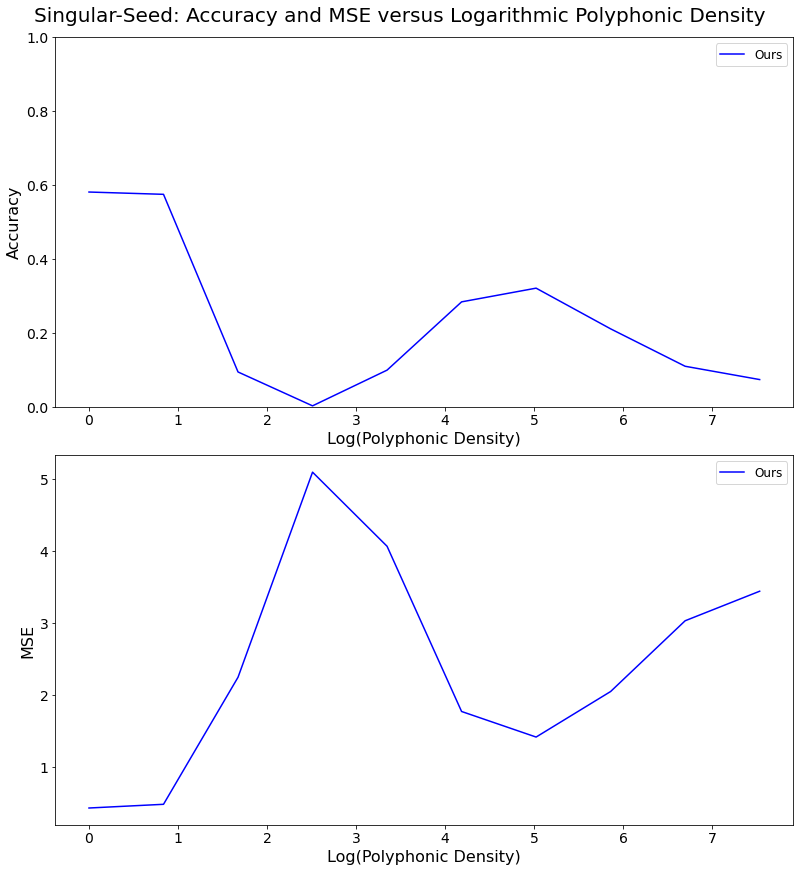

In [129]:
fig, ax = plt.subplots(2, 1, figsize=(11, 12), constrained_layout=True)

'''
ax[0].plot(list(PD_metric), PD_metric_acc_lib, color='y', 
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[0].plot(list(PD_metric), PD_metric_acc_aub, color='r', 
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
'''
ax[0].plot(list(PD_metric), PD_metric_acc, color='b', 
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[0].set_xlabel("Log(Polyphonic Density)", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].set_ylim([0, 1])
ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 

'''
ax[1].plot(list(PD_metric), PD_metric_MSE_lib, color='y',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[1].plot(list(PD_metric), PD_metric_MSE_aub, color='r',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
'''
ax[1].plot(list(PD_metric), PD_metric_MSE, color='b',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[1].set_xlabel("Log(Polyphonic Density)", fontsize=16)
ax[1].set_ylabel("MSE", fontsize=16)
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=14) 
ax[1].tick_params(axis="y", labelsize=14) 

fig.suptitle("Singular-Seed: Accuracy and MSE versus Logarithmic Polyphonic Density", fontsize=20)

ax[0].legend(loc='best', prop={'size': 12})
ax[1].legend(loc='best', prop={'size': 12})

fig.savefig(join('images', 'RO1-10_PD'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#### 2. Four-bird v.s. other methods

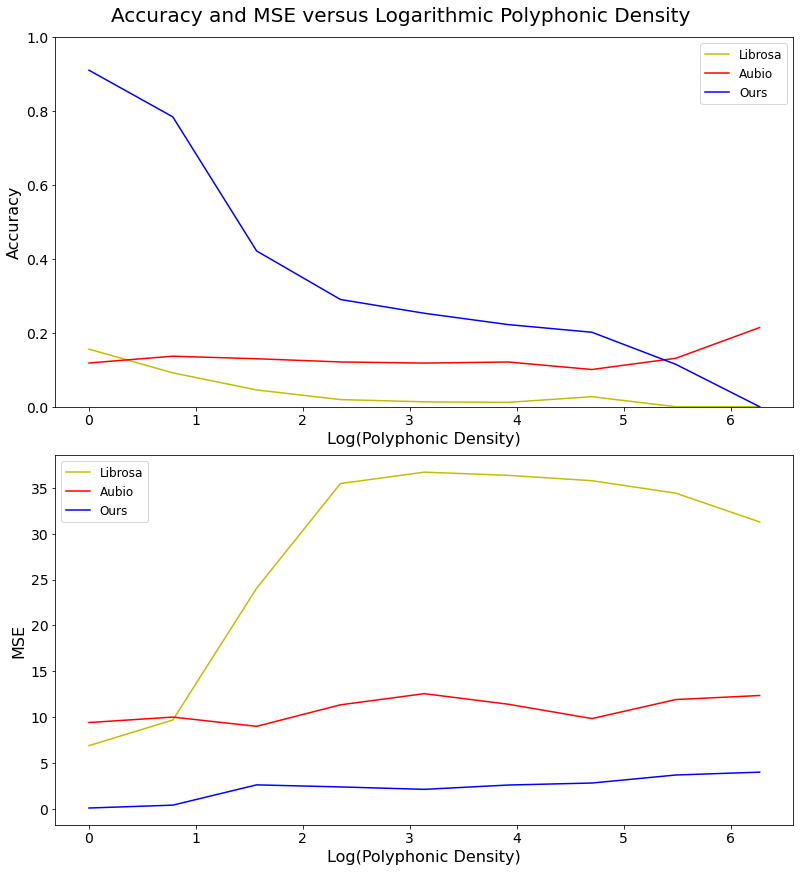

In [185]:
fig, ax = plt.subplots(2, 1, figsize=(11, 12), constrained_layout=True)

ax[0].plot(list(PD_metric), PD_metric_acc_lib, color='y', 
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[0].plot(list(PD_metric), PD_metric_acc_aub, color='r', 
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
ax[0].plot(list(PD_metric), PD_metric_acc, color='b', 
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[0].set_xlabel("Log(Polyphonic Density)", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].set_ylim([0, 1])
ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 

ax[1].plot(list(PD_metric), PD_metric_MSE_lib, color='y',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[1].plot(list(PD_metric), PD_metric_MSE_aub, color='r',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
ax[1].plot(list(PD_metric), PD_metric_MSE, color='b',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[1].set_xlabel("Log(Polyphonic Density)", fontsize=16)
ax[1].set_ylabel("MSE", fontsize=16)
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=14) 
ax[1].tick_params(axis="y", labelsize=14) 
'''
ax[2].plot(list(PL_metric), metric_MDE, color='g',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[2].set_xlabel("Polyphonic Area", fontsize=16)
ax[2].set_ylabel("MDE", fontsize=16)
ax[2].set_ylim([0, 1])
'''
fig.suptitle("Accuracy and MSE versus Logarithmic Polyphonic Density", fontsize=20)

ax[0].legend(loc='best', prop={'size': 12})
ax[1].legend(loc='best', prop={'size': 12})

fig.savefig(join('images', '40K_PD_lib_aub'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()